In [118]:
import os

# Path to the dataset in Kaggle environment
dataset_path = '/kaggle/input/sports-image-classification/dataset/'

# List all files in the dataset directory
file_names = os.listdir(dataset_path)

print(file_names[:5])
print("you dataset is imported succefully ")

['sample_submission.csv', 'train.csv', 'test.csv', 'test', 'train']
you dataset is imported succefully 


In [119]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard,  LearningRateScheduler
import datetime
import os
import cv2
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import pointbiserialr
from statsmodels.stats.outliers_influence import variance_inflation_factor
print("all imports is successfully imported ")






all imports is successfully imported 


In [120]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [121]:
# Part I: Data Preparation

# 1. Load and Describe the Data
# Path to the dataset in Kaggle environment
train_data_path = '/kaggle/input/sports-image-classification/dataset/train.csv'
test_data_path = '/kaggle/input/sports-image-classification/dataset/test.csv'

# Load the CSV files
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)
print("the data imported successfully")

the data imported successfully


In [122]:
print("Train CSV Info (8227 images):")
print(train_df.info())
print("\nTrain CSV Head:")
print(train_df.head())
print("\nTest CSV Info (2056 images):")
print(test_df.info())
print("\nTest CSV Head:")
print(test_df.head())

Train CSV Info (8227 images):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8227 entries, 0 to 8226
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_ID  8227 non-null   object
 1   label     8227 non-null   object
dtypes: object(2)
memory usage: 128.7+ KB
None

Train CSV Head:
         image_ID      label
0  7c225f7b61.jpg  Badminton
1         b31.jpg  Badminton
2  acb146546c.jpg  Badminton
3  0e62f4d8f2.jpg  Badminton
4  cfd2c28c74.jpg    Cricket

Test CSV Info (2056 images):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2056 entries, 0 to 2055
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_ID  2056 non-null   object
dtypes: object(1)
memory usage: 16.2+ KB
None

Test CSV Head:
         image_ID
0  f5e13966e7.jpg
1  6674191b4e.jpg
2  91b5f8b7a9.jpg
3  393119b6d6.jpg
4  1ce5f81578.jpg


In [123]:
image_col = 'image_ID'
label_col = 'label'

In [124]:
print("\nLabel Distribution:")
print(train_df[label_col].value_counts())


Label Distribution:
label
Cricket      1556
Wrestling    1471
Tennis       1445
Badminton    1394
Soccer       1188
Swimming      595
Karate        578
Name: count, dtype: int64


In [125]:
# 2. Clean the Data
print("\nMissing Values in Train CSV:")
print(train_df.isnull().sum())
train_df.dropna(inplace=True)


Missing Values in Train CSV:
image_ID    0
label       0
dtype: int64


In [126]:
print("\nNumber of Duplicates in Train CSV:", train_df.duplicated().sum())
train_df.drop_duplicates(inplace=True)


Number of Duplicates in Train CSV: 0


In [127]:
def verify_images(df, folder_path):
    missing_images = []
    for idx, row in df.iterrows():
        # Adjusted path to reflect Kaggle input directory
        img_path = os.path.join(folder_path, row[image_col])
        if not os.path.exists(img_path):
            missing_images.append(row[image_col])
    return missing_images

# Correct path to the dataset in Kaggle environment
train_images_folder = '/kaggle/input/sports-image-classification/dataset/train'

# Now call the function to verify images
missing_train_images = verify_images(train_df, train_images_folder)
print("\nMissing Training Images:", len(missing_train_images))


Missing Training Images: 0


In [128]:
# 3. Load Images and Prepare for PCA
IMG_SIZE = 64
CHANNELS = 3  # Set to 3 for RGB; 
# Paths
TRAIN_CSV     = '/kaggle/input/sports-image-classification/dataset/train.csv'
TEST_CSV      = '/kaggle/input/sports-image-classification/dataset/test.csv'
TRAIN_IMG_DIR = '/kaggle/input/sports-image-classification/dataset/train'
TEST_IMG_DIR  = '/kaggle/input/sports-image-classification/dataset/test'

In [130]:
def load_images(df, directory, img_size=IMG_SIZE):
  
    images = []
    labels = []
    
    for _, row in df.iterrows():
        try:
            # Load and resize image
            img_path = os.path.join(directory, row['image_ID'])
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (img_size, img_size))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                images.append(img)
                labels.append(row['label'])
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    
    return np.array(images), np.array(labels)

print("\nLoading training images...")
X_train, y_train = load_images(train_df, TRAIN_IMG_DIR)
print(f"Loaded {len(X_train)} images")


Loading training images...
Loaded 8227 images


In [81]:
X_pca, y = load_images(train_df, '/kaggle/input/sports-image-classification/dataset/train', for_pca=True)
X_cnn, _ = load_images(train_df, '/kaggle/input/sports-image-classification/dataset/train', for_pca=False)
X_cnn = X_cnn.reshape(-1, IMG_SIZE, IMG_SIZE, CHANNELS)  # Shape for CNN: (samples, 64, 64, 3) for RGB
# To use grayscale, ensure CHANNELS = 1 above, and this line will reshape to (samples, 64, 64, 1)

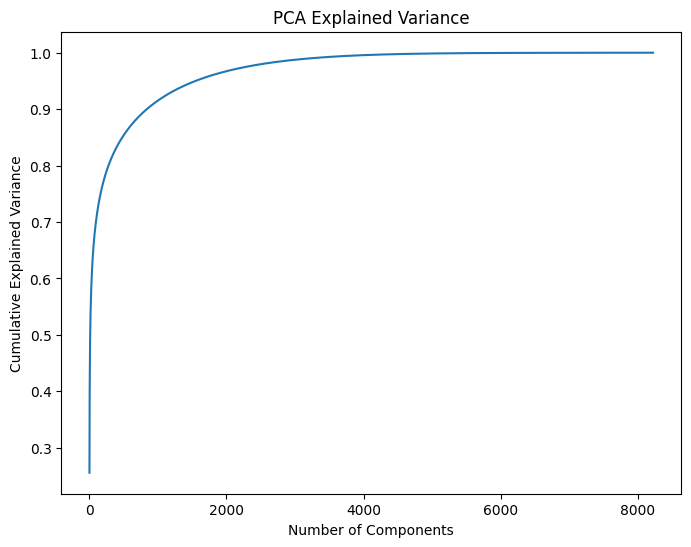


Number of components explaining 95% variance: 1549
PCA is useful: Significant dimensionality reduction achieved.


In [82]:
# 4. PCA Analysis
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

pca = PCA()
pca.fit(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')

# Display the plot instead of saving it
plt.show()  # This will show the plot


n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.95) + 1
print(f"\nNumber of components explaining 95% variance: {n_components}")
if n_components < X_pca.shape[1] * 0.5:
    print("PCA is useful: Significant dimensionality reduction achieved.")
    pca = PCA(n_components=n_components)
    X_pca_transformed = pca.fit_transform(X_scaled)
else:
    print("PCA is not useful: Most features are needed to explain variance.")
    X_pca_transformed = X_scaled

/tmp/ipykernel_31/1121978738.py:12: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



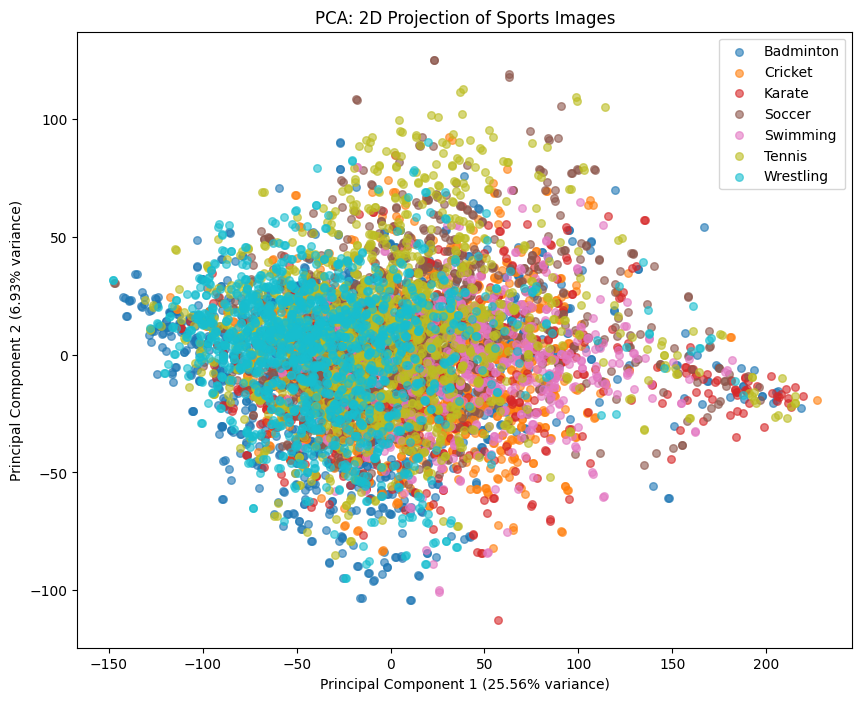

In [83]:
# Add PCA Scatter Plot: Project data onto first two components
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)  # Shape: (8227, 2)

# Explained variance for the first two components
var_pc1 = pca_2d.explained_variance_ratio_[0] * 100
var_pc2 = pca_2d.explained_variance_ratio_[1] * 100

# Create a scatter plot, coloring by sport labels
plt.figure(figsize=(10, 8))
unique_labels = np.unique(y)
colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Use tab10 colormap for distinct colors

for idx, label in enumerate(unique_labels):
    mask = y == label
    plt.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
                label=label, color=colors(idx), alpha=0.6, s=30)

plt.xlabel(f'Principal Component 1 ({var_pc1:.2f}% variance)')
plt.ylabel(f'Principal Component 2 ({var_pc2:.2f}% variance)')
plt.title('PCA: 2D Projection of Sports Images')
plt.legend()
plt.show()

In [131]:
# 5. Encode Labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

In [132]:
# Print original and encoded labels
print("Original Labels:", y[:10])  # Print the first 10 original labels
print("Encoded Labels:", y_encoded[:10])  # Print the first 10 encoded labels

# Print a mapping between original labels and encoded values
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Label to Encoded Value Mapping:", label_mapping)

# If you want to print the reverse mapping (encoded value to original label):
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
print("Encoded Value to Label Mapping:", reverse_label_mapping)


Original Labels: ['Badminton' 'Badminton' 'Badminton' 'Badminton' 'Cricket' 'Tennis'
 'Badminton' 'Swimming' 'Badminton' 'Badminton']
Encoded Labels: [0 0 0 0 1 5 0 4 0 0]
Label to Encoded Value Mapping: {'Badminton': 0, 'Cricket': 1, 'Karate': 2, 'Soccer': 3, 'Swimming': 4, 'Tennis': 5, 'Wrestling': 6}
Encoded Value to Label Mapping: {0: 'Badminton', 1: 'Cricket', 2: 'Karate', 3: 'Soccer', 4: 'Swimming', 5: 'Tennis', 6: 'Wrestling'}


In [133]:
# X_train, X_val, y_train, y_val = train_test_split(X_cnn, y_encoded, test_size=0.2, random_state=42)

In [136]:
# === Load data in non-flattened format for training ===
train_df = pd.read_csv(TRAIN_CSV)
X_train, y_train = load_images(train_df, TRAIN_IMG_DIR, img_size=IMG_SIZE)

# === Encode labels ===
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# === Augmentation Parameters ===
augmentation_factor = 3

print(f"Starting augmentation with factor {augmentation_factor}...")
print(f"Original data shape: {X_train.shape}")

aug_images = []
aug_labels = []

# Add original images
aug_images.extend(X_train)
aug_labels.extend(y_train_encoded)

# Create augmented versions
for i in range(len(X_train)):
    img = X_train[i]
    lbl = y_train_encoded[i]

    for _ in range(augmentation_factor - 1):
        aug_img = img.copy()

        if np.random.rand() > 0.5:
            aug_img = cv2.flip(aug_img, 1)
        if np.random.rand() > 0.5:
            angle = np.random.uniform(-15, 15)
            h, w = aug_img.shape[:2]
            M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
            aug_img = cv2.warpAffine(aug_img, M, (w, h))
        if np.random.rand() > 0.5:
            brightness = np.random.uniform(0.8, 1.2)
            aug_img = np.clip(aug_img * brightness, 0, 255).astype(np.uint8)

        aug_images.append(aug_img)
        aug_labels.append(lbl)

aug_images = np.array(aug_images)
aug_labels = np.array(aug_labels)

print(f"Augmented data shape: {aug_images.shape}")

# === Split into Train/Val ===
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    aug_images, aug_labels,
    test_size=0.2,
    random_state=42,
    stratify=aug_labels
)

print(f"Training set: {len(X_train_split)} images")
print(f"Validation set: {len(X_val_split)} images")


Starting augmentation with factor 3...
Original data shape: (8227, 64, 64, 3)
Augmented data shape: (24681, 64, 64, 3)
Training set: 19744 images
Validation set: 4937 images


In [137]:
# Compute the mean and standard deviation for the training set
train_mean = np.mean(X_train, axis=(0, 1, 2))  # Mean for each channel (RGB)
train_std = np.std(X_train, axis=(0, 1, 2))  # Std for each channel (RGB)

# Standardize the data using the mean and std computed from the training set
X_train_standardized = (X_train - train_mean) / train_std
X_val_standardized = (X_val - train_mean) / train_std  # Use the training set's mean and std for validation set

# Define the ImageDataGenerators for data augmentation and rescaling
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator()  # No augmentation for validation set

# Apply the standardization (mean subtraction and division by std) to the train and validation sets
train_generator = train_datagen.flow(X_train_standardized, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val_standardized, y_val, batch_size=32)


In [138]:
# 5. Check Consistency Between Training and Validation Data Standardization
print("\nEnsure that the training and validation data have similar mean and standard deviation:")
print("Training Mean:", np.mean(X_train_standardized, axis=(0, 1, 2)))
print("Validation Mean:", np.mean(X_val_standardized, axis=(0, 1, 2)))

print("\nTraining Std:", np.std(X_train_standardized, axis=(0, 1, 2)))
print("Validation Std:", np.std(X_val_standardized, axis=(0, 1, 2)))


Ensure that the training and validation data have similar mean and standard deviation:
Training Mean: [-3.95055576e-14 -2.93520515e-14 -5.30890838e-14]
Validation Mean: [-0.00878186  0.00547779  0.0104994 ]

Training Std: [1. 1. 1.]
Validation Std: [0.99904398 0.99743041 1.00319308]


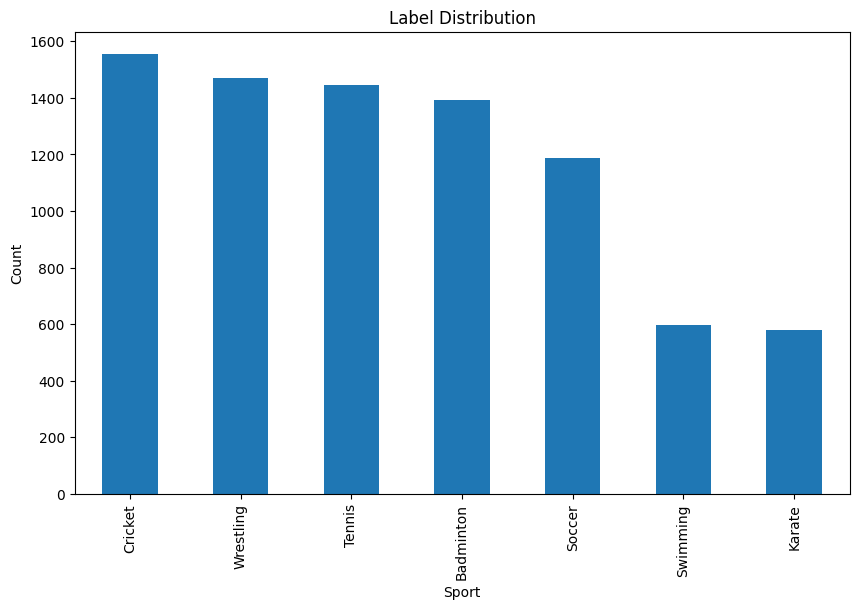

In [139]:
#visualize all data (not train data only )
plt.figure(figsize=(10, 6))
train_df[label_col].value_counts().plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Sport')
plt.ylabel('Count')

# Show the plot in the notebook instead of saving it
plt.show()



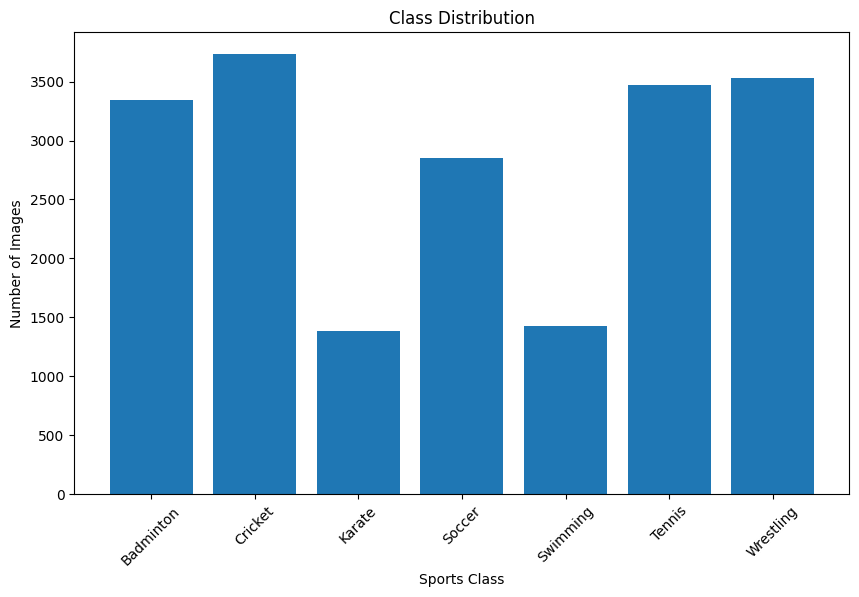

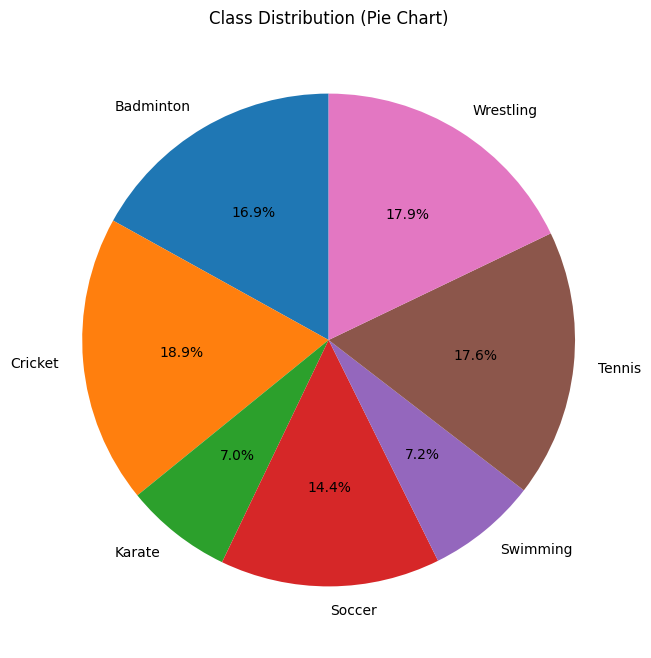

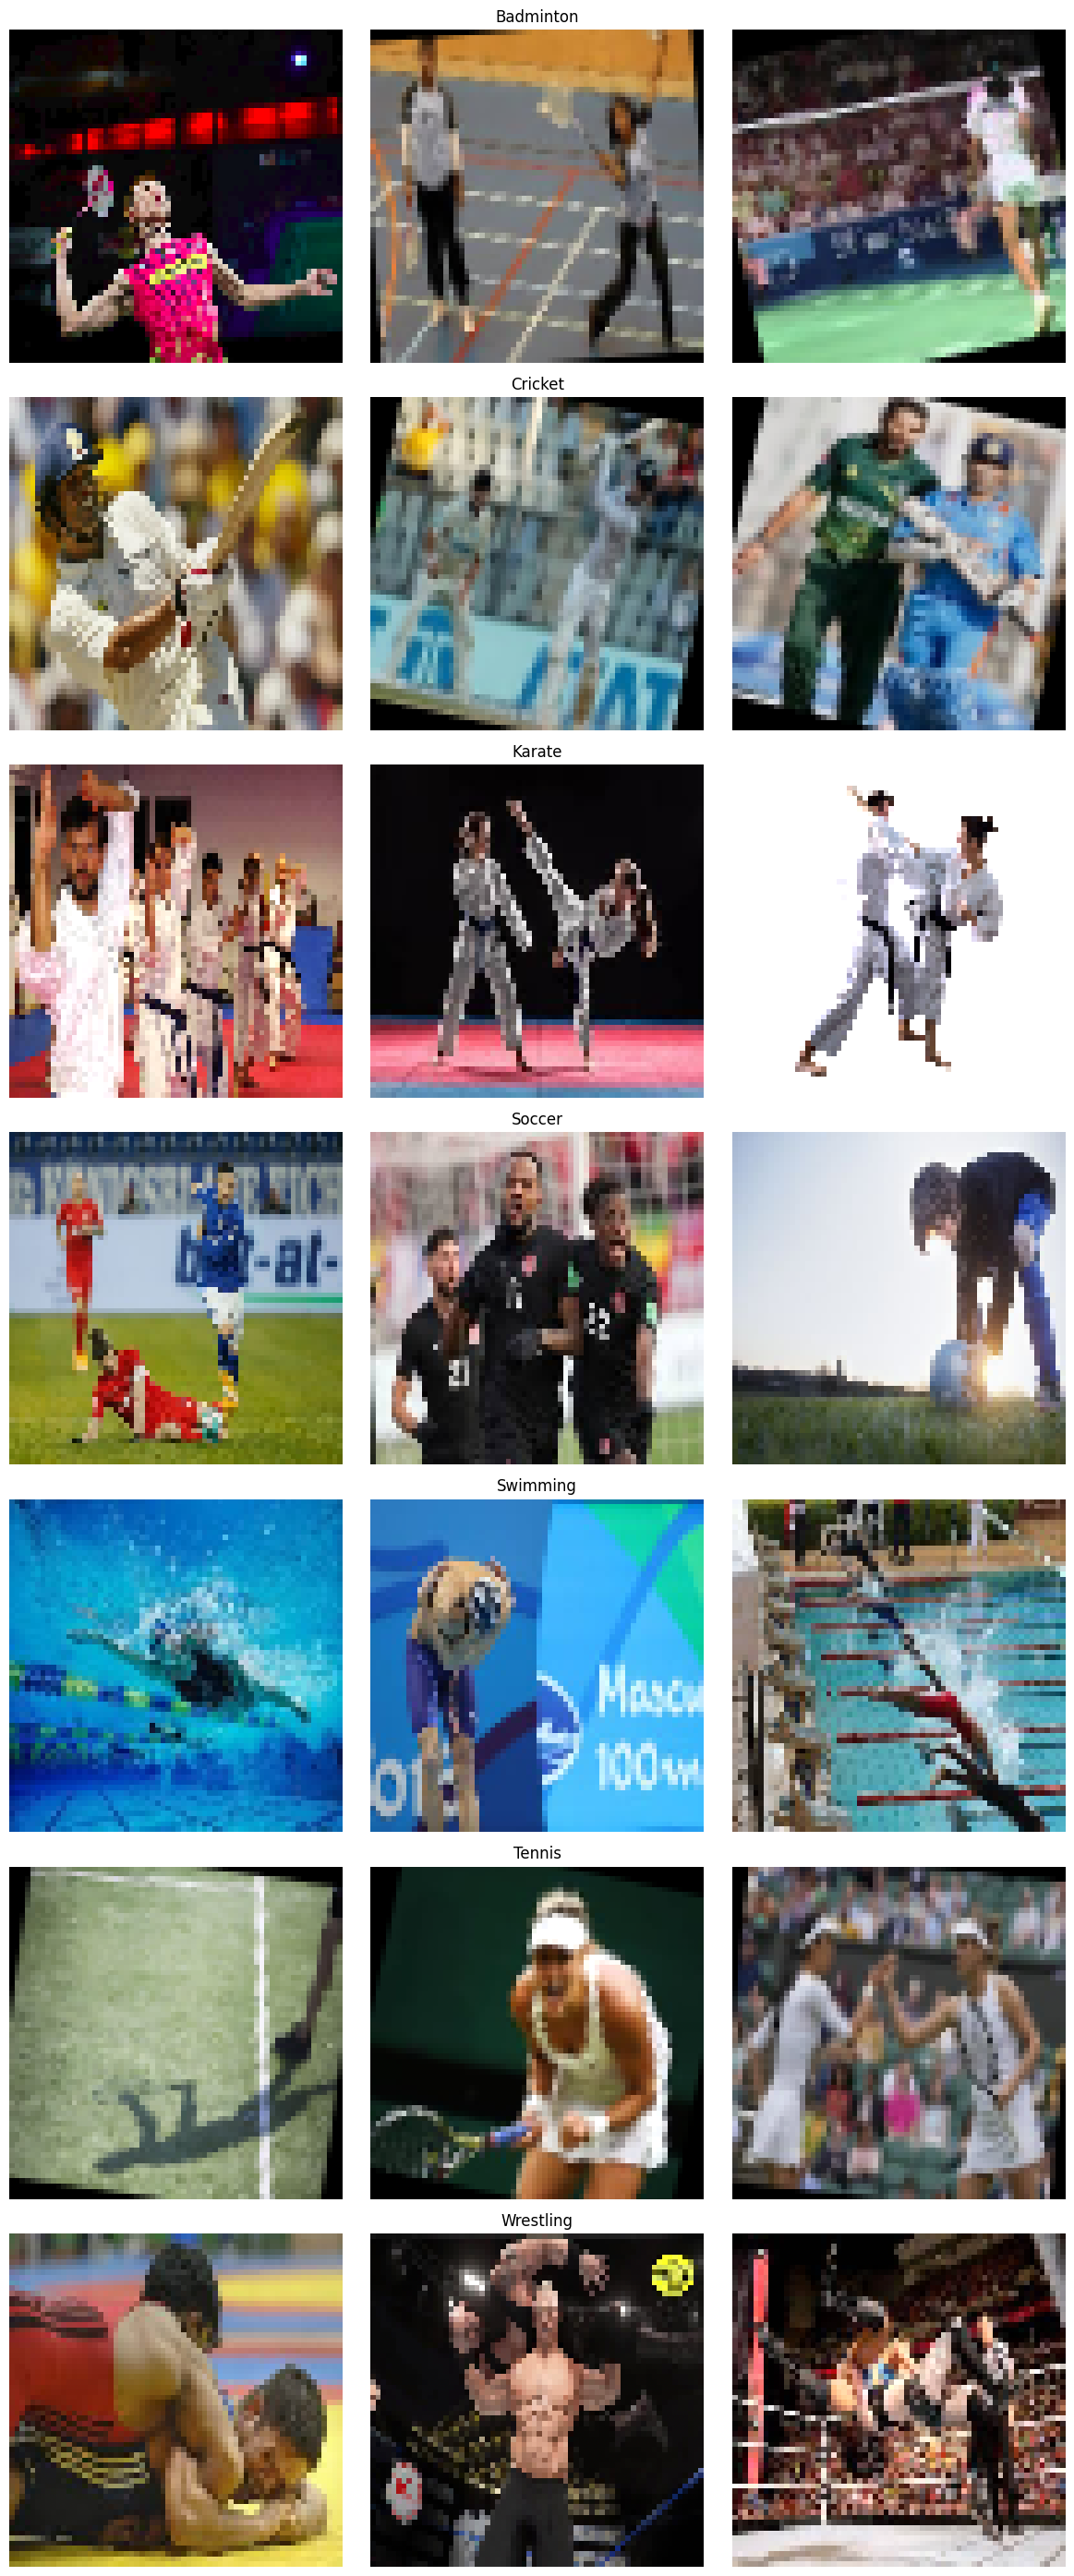

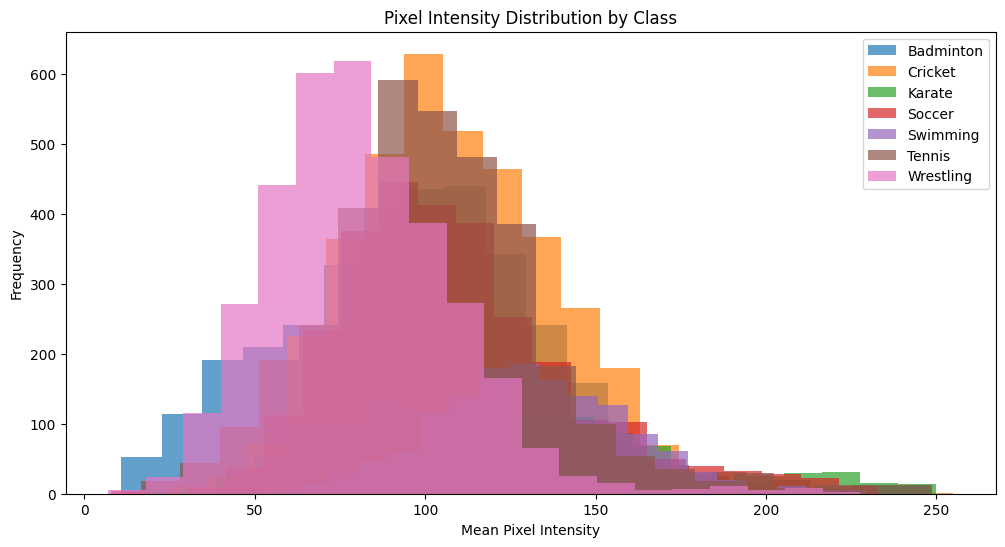

In [140]:
# 8. Visualize Data



def visualize_data(train_images, train_labels, class_names):

    # Label distribution bar chart
    plt.figure(figsize=(10, 6))
    unique, counts = np.unique(train_labels, return_counts=True)
    plt.bar(class_names, counts)
    plt.title('Class Distribution')
    plt.xlabel('Sports Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

    # Pie chart for class distribution
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=90)
    plt.title('Class Distribution (Pie Chart)')
    plt.show()

    # Image montage by class
    num_classes = len(class_names)
    fig, axes = plt.subplots(num_classes, 3, figsize=(12, 4 * num_classes))
    for i, class_name in enumerate(class_names):
        class_indices = np.where(train_labels == i)[0]
        sample_indices = np.random.choice(class_indices, 3, replace=False)
        for j, idx in enumerate(sample_indices):
            axes[i, j].imshow(train_images[idx])
            axes[i, j].axis('off')
            if j == 1:
                axes[i, j].set_title(f'{class_name}')
    plt.tight_layout()
    plt.show()

    # Pixel intensity histograms
    plt.figure(figsize=(12, 6))
    for i, class_name in enumerate(class_names):
        class_images = train_images[train_labels == i]
        mean_intensities = np.mean(class_images, axis=(1, 2, 3))  # Averaging over the image dimensions
        plt.hist(mean_intensities, bins=20, alpha=0.7, label=class_name)
    plt.title('Pixel Intensity Distribution by Class')
    plt.xlabel('Mean Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Example usage
visualize_data(X_train, y_train, class_names)

In [141]:
# 9. Correlation Analysis (Interactive HTML Heatmap with Negative Correlations)
# Compute correlation matrix
pixel_corr = pd.DataFrame(X_pca).iloc[::5, ::5].corr()  # Shape: (2458, 2458)

# Check for negative correlations in the first subsampled matrix
print("\nChecking for negative correlations in first subsampled matrix:")
negative_corrs = pixel_corr[pixel_corr < 0].stack()
if not negative_corrs.empty:
    print(f"Found {len(negative_corrs)} negative correlations. Sample:")
    print(negative_corrs.head())
else:
    print("No negative correlations found.")

# Subsample to reduce size while ensuring negative correlations are included
step = 100  # Reduces from 2458 to ~25 (2458 / 100)
# Select indices to include some negative correlations
# Find pairs with negative correlations
neg_pairs = np.where(pixel_corr < -0.1)  # Threshold to find significant negative correlations
neg_indices = list(set(neg_pairs[0]))  # Unique indices with negative correlations

# Ensure we include some indices with negative correlations
num_indices_to_include = min(5, len(neg_indices))  # Include up to 5 indices with negative correlations
selected_neg_indices = neg_indices[:num_indices_to_include] if neg_indices else []

# Create a list of indices for subsampling, including negative correlation indices
subsample_indices = list(range(0, pixel_corr.shape[0], step))  # Default subsampling: 0, 100, ..., 2400
# Add some indices with negative correlations
for idx in selected_neg_indices:
    closest_subsample_idx = (idx // step) * step  # Align with step
    if closest_subsample_idx not in subsample_indices:
        subsample_indices.append(closest_subsample_idx)

subsample_indices = sorted(set(subsample_indices))  # Remove duplicates and sort
subsample_indices = subsample_indices[:25]  # Limit to 25 indices to keep heatmap manageable

# Subsample the correlation matrix using selected indices
subsampled_corr = pixel_corr.iloc[subsample_indices, subsample_indices].values

# Map subsampled indices back to original indices
original_indices = np.array(subsample_indices) * 5  # Map to original feature space: [0, 500, ..., 12000]

# Create tick labels for the heatmap
num_ticks = min(10, len(original_indices))
tick_positions = np.linspace(0, len(original_indices) - 1, num_ticks).astype(int)
tick_labels = original_indices[tick_positions]

# Create text annotations (rounded correlation values)
text_annotations = np.round(subsampled_corr, 2).astype(str)

# Create interactive heatmap with Plotly
fig = go.Figure(data=go.Heatmap(
    z=subsampled_corr,
    x=original_indices,
    y=original_indices,
    colorscale='RdBu',
    zmin=-1, zmax=1,
    colorbar=dict(title='Correlation'),
    text=text_annotations,
    texttemplate="%{text}",
    textfont=dict(size=10),
))

fig.update_layout(
    title='Pixel Correlation Heatmap (Subsampled)',
    xaxis_title='Pixel Index (Subsampled)',
    yaxis_title='Pixel Index (Subsampled)',
    xaxis=dict(tickvals=tick_labels, ticktext=[str(val) for val in tick_labels]),
    yaxis=dict(tickvals=tick_labels, ticktext=[str(val) for val in tick_labels]),
    autosize=True,
    margin=dict(l=50, r=50, t=100, b=50),
)

fig.write_html(
    'pixel_correlation_interactive.html',
    include_plotlyjs='cdn',
    post_script="""
    const style = document.createElement('style');
    style.innerHTML = `
        #graph { width: 100vw !important; height: 100vh !important; }
        body { margin: 0; padding: 0; overflow: hidden; }
    `;
    document.head.appendChild(style);
    """
)
print("\nInteractive heatmap saved as 'pixel_correlation_interactive.html'")
print("Open the HTML file in a browser to view the full-screen heatmap .")


Checking for negative correlations in first subsampled matrix:
Found 6 negative correlations. Sample:
2635   11835   -0.002409
3020   11835   -0.007049
7960   11835   -0.006249
11835  2635    -0.002409
       3020    -0.007049
dtype: float64

Interactive heatmap saved as 'pixel_correlation_interactive.html'
Open the HTML file in a browser to view the full-screen heatmap .


In [54]:
# Part II: Training a Neural Network

# Requirement 1: Implement a CNN model
def create_cnn_model(input_shape=(224, 224, 3), num_classes=6):
    """
    Creates an enhanced CNN model for sports image classification.
    - Deeper network
    - Batch Normalization
    - Dropout for regularization
    """
    model = keras.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Classification Head
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model


# Requirement 2: Write a training function
def train_model(model, optimizer, batch_size, epochs=50):
    """
    Trains the model with early stopping and learning rate scheduling.
    
    Parameters:
    - model: CNN model to train
    - optimizer: Optimizer instance
    - batch_size: Batch size for training
    - epochs: Maximum number of epochs
    
    Returns:
    - History object
    """
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    
    # Define the learning rate schedule
    lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9, staircase=True)
    
    # Wrap the schedule to ensure the output is a Python float
    def schedule(epoch):
        lr = lr_schedule(epoch)
        return float(lr)  # Explicitly cast to Python float
    
    lr_scheduler = LearningRateScheduler(schedule)
    
    log_dir = "/kaggle/working/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[early_stopping, lr_scheduler, tensorboard_callback],
        verbose=1
    )
    return history

# Requirement 3: Evaluate the model
def evaluate_model(model):
    """
    Evaluates the model on training and validation sets.
    
    Parameters:
    - model: Trained CNN model
    
    Returns:
    - Tuple of (train_accuracy, val_accuracy)
    """
    train_loss, train_acc = model.evaluate(train_generator, verbose=0)
    val_loss, val_acc = model.evaluate(val_generator, verbose=0)
    print(f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
    return train_acc, val_acc
def update_generators(batch_size):
    """
    Updates data generators with a new batch size.
    
    Parameters:
    - batch_size: New batch size
    """
    global train_generator, val_generator
    train_generator = train_datagen.flow(X_train_standardized, y_train, batch_size=batch_size)
    val_generator = val_datagen.flow(X_val_standardized, y_val, batch_size=batch_size)


In [ ]:
BEST_PARAMS = {
    'batch_size': 32,          # From your best_batch
    'num_layers': 3,           # From your best_layers (unused in structure)
    'dropout_rate': 0.2,       # From your best_dropout
    'weight_decay': 0.0,       # From your best_wd
    'optimizer': 'Adam',       # From your best_opt
    'learning_rate': 0.001     # Default for Adam
}

# ========= CONFIGURATION =========
IMG_SIZE    = 64
CHANNELS    = 3
NUM_CLASSES = 7   # adjust to your number of sports classes

IMAGE_COL = 'image_ID'
LABEL_COL = 'label'

# Paths in Kaggle environment
TRAIN_IMG_FOLDER = '/kaggle/input/sports-image-classification/dataset/train'
TEST_IMG_FOLDER  = '/kaggle/input/sports-image-classification/dataset/test'
TRAIN_CSV        = '/kaggle/input/sports-image-classification/dataset/train.csv'
TEST_CSV         = '/kaggle/input/sports-image-classification/dataset/test.csv'

# ===== FUNCTIONS DEFINITION =====
def verify_images(df, folder_path):
    missing = []
    for _, row in df.iterrows():
        path = os.path.join(folder_path, row[IMAGE_COL])
        if not os.path.exists(path):
            missing.append(row[IMAGE_COL])
    return missing


def load_images(df, folder_path, img_size=IMG_SIZE):
    imgs, labels = [], []
    for _, row in df.iterrows():
        img_path = os.path.join(folder_path, row[IMAGE_COL])
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            continue
        img = cv2.resize(img, (img_size, img_size))
        if CHANNELS == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
        labels.append(row[LABEL_COL])
    return np.array(imgs), np.array(labels)


def load_test_images(df, folder_path, img_size=IMG_SIZE):
    imgs = []
    for _, row in df.iterrows():
        img_path = os.path.join(folder_path, row[IMAGE_COL])
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            continue
        img = cv2.resize(img, (img_size, img_size))
        if CHANNELS == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
    return np.array(imgs)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS), num_classes=NUM_CLASSES):
    weight_decay = BEST_PARAMS.get('weight_decay', 0.001)

    model = keras.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay), input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Classifier
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(weight_decay)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

def train_model(train_gen, val_gen, class_weight_dict, epochs=50):
    model = create_cnn_model()
    model.compile(
        optimizer=Adam(learning_rate=BEST_PARAMS['learning_rate']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    callbacks = [
        EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
        ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
    ]
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks,
        class_weight=class_weight_dict
    )
    return model, history


def plot_history(history):
    plt.figure()
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [ ]:
# ===== TRAINING PART for model with best hyper parameters =====
# 1) Load and verify training data
train_df = pd.read_csv(TRAIN_CSV)
missing = verify_images(train_df, TRAIN_IMG_FOLDER)
print(f"Missing train images: {len(missing)}")

# 2) Load all images and labels
X_all, y_all_raw = load_images(train_df, TRAIN_IMG_FOLDER)

# 3) Encode labels
le = LabelEncoder()
y_all = le.fit_transform(y_all_raw)

# 4) Split into train/val sets
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)

# 5) Compute class weights
weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train
)
class_weight_dict = dict(enumerate(weights))

# 6) Standardize data
train_mean = X_train.mean(axis=(0,1,2))
train_std  = X_train.std(axis=(0,1,2))
X_train_std = (X_train - train_mean) / train_std
X_val_std   = (X_val   - train_mean) / train_std

# 7) Data generators
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
val_datagen  = ImageDataGenerator()

train_gen = train_datagen.flow(
    X_train_std, y_train,
    batch_size=BEST_PARAMS['batch_size']
)
val_gen = val_datagen.flow(
    X_val_std, y_val,
    batch_size=BEST_PARAMS['batch_size']
)

# 8) Train model
model, history = train_model(train_gen, val_gen, class_weight_dict)

# 9) Plot training history
plot_history(history)

In [ ]:
# ===== TESTING & SUBMISSION PART for model with best hyper parameter =====
# 1) Load and standardize test data
test_df = pd.read_csv(TEST_CSV)
X_test = load_test_images(test_df, TEST_IMG_FOLDER)
X_test_std = (X_test - train_mean) / train_std

test_datagen = ImageDataGenerator()
test_gen = test_datagen.flow(
    X_test_std,
    shuffle=False,
    batch_size=BEST_PARAMS['batch_size']
)

# 2) Predict and inspect distribution
preds = model.predict(test_gen)
pred_classes = np.argmax(preds, axis=1)
uniq, counts = np.unique(pred_classes, return_counts=True)
print("Prediction distribution:", dict(zip(uniq, counts)))

# 3) Save submission.csv
pred_labels = le.inverse_transform(pred_classes)
submission = pd.DataFrame({
    IMAGE_COL: test_df[IMAGE_COL],
    LABEL_COL: pred_labels
})
submission.to_csv('submission.csv', index=False)

# 4) Save final model
model.save('best_sports_classifier.keras')

# All Steps in more organized way 

# Functions definition

In [142]:
# # ========= INITIAL PARAMETERS =========
BEST_PARAMS = {
    'batch_size': 32,
    'num_layers': 3,           # Not used, but kept for reference
    'dropout_rate': 0.2,       # Optional override
    'weight_decay': 0.001,     # Used in model
    'optimizer': 'Adam',
    'learning_rate': 0.001
}
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers, models, regularizers

mixed_precision.set_global_policy('mixed_float16')

# ========= CONFIGURATION =========
IMG_SIZE = 64
CHANNELS    = 3
NUM_CLASSES = 7
IMAGE_COL   = 'image_ID'
LABEL_COL   = 'label'
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, CHANNELS)

def build_cnn_model(num_layers=3, dropout_rate=0.3, weight_decay=1e-4):
    """
    Builds a custom CNN with variable number of convolutional blocks,
    dropout, and L2 regularization.
    
    Parameters:
    - num_layers: int, number of conv blocks to use (2–5 recommended)
    - dropout_rate: float, dropout rate for regularization
    - weight_decay: float, L2 regularization factor
    
    Returns:
    - Compiled Keras model
    """
    model = models.Sequential()
    model.add(layers.Input(shape=INPUT_SHAPE))

    for i in range(num_layers):
        filters = min(32 * (2 ** i), 256)  # Gradually increase, max out at 256
        model.add(layers.Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu',
                                kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu',
                                kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu',
                           kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.6))
    model.add(layers.Dense(7, activation='softmax'))

    return model

print("run")

run


In [143]:
# ===== FUNCTIONS DEFINITION =====
def verify_images(df, folder_path):
    missing = []
    for _, row in df.iterrows():
        path = os.path.join(folder_path, row[IMAGE_COL])
        if not os.path.exists(path):
            missing.append(row[IMAGE_COL])
    return missing

def load_test_images(df, folder_path, img_size=IMG_SIZE):
    imgs = []
    for _, row in df.iterrows():
        img_path = os.path.join(folder_path, row[IMAGE_COL])
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            continue
        img = cv2.resize(img, (img_size, img_size))
        if CHANNELS == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
    return np.array(imgs)


# LOAD & PREPARE

In [96]:
# def augment_images(images, labels, augmentation_factor=2):

#     print(f"Starting augmentation with factor {augmentation_factor}...")
#     print(f"Original data shape: {images.shape}")

#     aug_images = []
#     aug_labels = []

#     aug_images.extend(images)
#     aug_labels.extend(labels)

#     for i in range(len(images)):
#         img = images[i]
#         lbl = labels[i]

#         for j in range(augmentation_factor - 1):
#             aug_img = img.copy()

#             if np.random.rand() > 0.5:
#                 aug_img = cv2.flip(aug_img, 1)

#             if np.random.rand() > 0.5:
#                 angle = np.random.uniform(-15, 15)
#                 h, w = aug_img.shape[:2]
#                 M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
#                 aug_img = cv2.warpAffine(aug_img, M, (w, h))

#             if np.random.rand() > 0.5:
#                 brightness = np.random.uniform(0.8, 1.2)
#                 aug_img = np.clip(aug_img * brightness, 0, 255).astype(np.uint8)

#             aug_images.append(aug_img)
#             aug_labels.append(lbl)

#     aug_images = np.array(aug_images)
#     aug_labels = np.array(aug_labels)

#     print(f"Augmented data shape: {aug_images.shape}")
#     return aug_images, aug_labels


In [98]:
# # === LOAD DATA ===
# train_df = pd.read_csv(TRAIN_CSV)
# test_df  = pd.read_csv(TEST_CSV)

# # Drop issues
# train_df.dropna(inplace=True)
# train_df.drop_duplicates(inplace=True)

# # Load full image set and labels
# X, y = load_images(train_df, TRAIN_IMG_DIR, img_size=IMG_SIZE, for_pca=False)


# # Label encoding
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# y_encoded = le.fit_transform(y)

# # === APPLY AUGMENTATION BEFORE SPLIT ===
# from sklearn.model_selection import train_test_split

# X_augmented, y_augmented = augment_images(X, y_encoded, augmentation_factor=2)

# # === SPLIT AFTER AUGMENTATION ===
# X_train, X_val, y_train, y_val = train_test_split(
#     X_augmented, y_augmented, test_size=0.2, stratify=y_augmented, random_state=42
# )

# # === NORMALIZE AFTER SPLIT ===
# X_train = X_train.astype('float32') / 255.0
# X_val   = X_val.astype('float32') / 255.0
# X_test  = load_test_images(test_df, TEST_IMG_DIR, img_size=IMG_SIZE)
# X_test  = X_test.astype('float32') / 255.0


Starting augmentation with factor 2...
Original data shape: (8227, 64, 64, 3)
Augmented data shape: (16454, 64, 64, 3)


In [144]:
def train_model_numpy(model,
                      X_train, y_train,
                      X_val, y_val,
                      optimizer_name='Adam',
                      learning_rate=0.001,
                      class_weight=None,
                      use_scheduler=True,
                      batch_size=32,
                      epochs=12):
    """
    Training function using NumPy arrays with NO augmentation — for hyperparameter exploration.
    """
    opt_cls = {'Adam': Adam, 'SGD': SGD, 'RMSprop': RMSprop}[optimizer_name]
    opt_kwargs = {'learning_rate': learning_rate}
    if optimizer_name == 'SGD':
        opt_kwargs['momentum'] = 0.9
    optimizer = opt_cls(**opt_kwargs)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    #  No augmentation during hyperparameter tuning
    X_train_scaled = X_train / 255.0
    X_val_scaled = X_val / 255.0

    callbacks = [EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)]
    if use_scheduler:
        callbacks.append(ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2))

    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        class_weight=class_weight,
        verbose=1
    )

    best_val_acc = max(history.history['val_accuracy'])
    return best_val_acc, history



 Training with num_layers = 2
Epoch 1/12
617/617 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.4045 - loss: 2.1479 - val_accuracy: 0.5584 - val_loss: 1.4387 - learning_rate: 0.0010
Epoch 2/12
617/617 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6183 - loss: 1.3397 - val_accuracy: 0.6273 - val_loss: 1.3012 - learning_rate: 0.0010
Epoch 3/12
617/617 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6776 - loss: 1.1308 - val_accuracy: 0.6976 - val_loss: 1.0523 - learning_rate: 0.0010
Epoch 4/12
617/617 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7173 - loss: 1.0066 - val_accuracy: 0.7401 - val_loss: 0.9276 - learning_rate: 0.0010
Epoch 5/12
617/617 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7462 - loss: 0.9102 - val_accuracy: 0.7610 - val_loss: 0.8991 - learning_rate: 0.0010
Epoch 6/12
617/617 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7747 - loss: 0.8351 - val_accuracy: 0.7154 - val_loss: 1.2457 - learning_rate: 0.0010
Epoch 7/12
617/617 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - ac

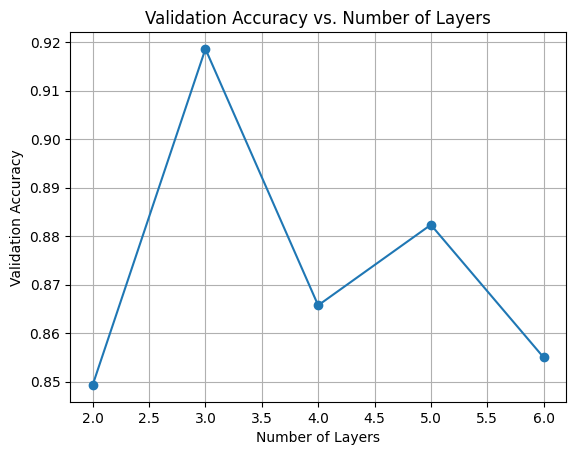


 Best num_layers = 3 with accuracy = 0.9186


In [145]:
# ====  Explore Number of Layers ====

layer_options = [2, 3, 4, 5, 6]
layer_results = {}

for n_layers in layer_options:
    print(f"\n Training with num_layers = {n_layers}")
    
    model = build_cnn_model(
        num_layers=n_layers,
        dropout_rate=BEST_PARAMS['dropout_rate'],
        weight_decay=BEST_PARAMS['weight_decay']
    )

    val_acc, _ = train_model_numpy(
        model,
        X_train, y_train,
        X_val, y_val,
        optimizer_name=BEST_PARAMS['optimizer'],
        learning_rate=BEST_PARAMS['learning_rate'],
        batch_size=BEST_PARAMS['batch_size']
    )

    layer_results[n_layers] = val_acc

# Plot results
plt.figure()
plt.plot(list(layer_results.keys()), list(layer_results.values()), marker='o')
plt.title('Validation Accuracy vs. Number of Layers')
plt.xlabel('Number of Layers')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

# Update best
BEST_PARAMS['num_layers'] = max(layer_results, key=layer_results.get)
print(f"\n Best num_layers = {BEST_PARAMS['num_layers']} with accuracy = {layer_results[BEST_PARAMS['num_layers']]:.4f}")



 Training with dropout_rate = 0.2
Epoch 1/12
617/617 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.4062 - loss: 2.4695 - val_accuracy: 0.6309 - val_loss: 1.5022 - learning_rate: 0.0010
Epoch 2/12
617/617 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6323 - loss: 1.5178 - val_accuracy: 0.6982 - val_loss: 1.3071 - learning_rate: 0.0010
Epoch 3/12
617/617 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7001 - loss: 1.2435 - val_accuracy: 0.7486 - val_loss: 1.0759 - learning_rate: 0.0010
Epoch 4/12
617/617 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7401 - loss: 1.0650 - val_accuracy: 0.7652 - val_loss: 1.0261 - learning_rate: 0.0010
Epoch 5/12
617/617 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7728 - loss: 0.9540 - val_accuracy: 0.7237 - val_loss: 1.1773 - learning_rate: 0.0010
Epoch 6/12
617/617 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7965 - loss: 0.8766 - val_accuracy: 0.7336 - val_loss: 1.0589 - learning_rate: 0.0010
Epoch 7/12
617/617 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

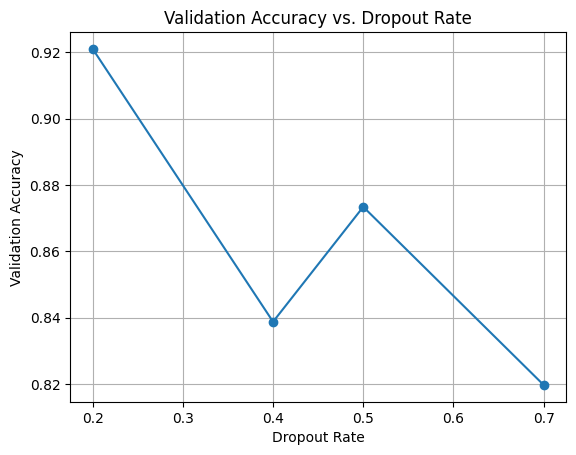


 Best dropout_rate = 0.2 with accuracy = 0.9210


In [146]:
# ==== Explore Dropout Rate ====

dropout_rates = [0.2, 0.4,0.5,0.7]
dropout_results = {}

for rate in dropout_rates:
    print(f"\n Training with dropout_rate = {rate}")
    
    model = build_cnn_model(
        num_layers=BEST_PARAMS['num_layers'],
        dropout_rate=rate,
        weight_decay=BEST_PARAMS['weight_decay']
    )

    val_acc, _ = train_model_numpy(
        model,
        X_train, y_train,
        X_val, y_val,
        optimizer_name=BEST_PARAMS['optimizer'],
        learning_rate=BEST_PARAMS['learning_rate'],
        batch_size=BEST_PARAMS['batch_size']
    )

    dropout_results[rate] = val_acc

# Plot
plt.figure()
plt.plot(dropout_results.keys(), dropout_results.values(), marker='o')
plt.title('Validation Accuracy vs. Dropout Rate')
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

# Update
BEST_PARAMS['dropout_rate'] = max(dropout_results, key=dropout_results.get)
print(f"\n Best dropout_rate = {BEST_PARAMS['dropout_rate']} with accuracy = {dropout_results[BEST_PARAMS['dropout_rate']]:.4f}")



 Training with batch_size = 16
Epoch 1/12
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.3818 - loss: 2.5233 - val_accuracy: 0.6121 - val_loss: 1.5502 - learning_rate: 0.0010
Epoch 2/12
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6048 - loss: 1.5299 - val_accuracy: 0.6372 - val_loss: 1.3447 - learning_rate: 0.0010
Epoch 3/12
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6692 - loss: 1.2589 - val_accuracy: 0.6356 - val_loss: 1.3224 - learning_rate: 0.0010
Epoch 4/12
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6998 - loss: 1.1322 - val_accuracy: 0.6686 - val_loss: 1.1872 - learning_rate: 0.0010
Epoch 5/12
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7241 - loss: 1.0729 - val_accuracy: 0.5919 - val_loss: 1.5456 - learning_rate: 0.0010
Epoch 6/12
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7489 - loss: 1.0118 - val_accuracy: 0.7099 - val_loss: 1.1784 - learning_rate: 0.0010
Epoch 7/12
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 6

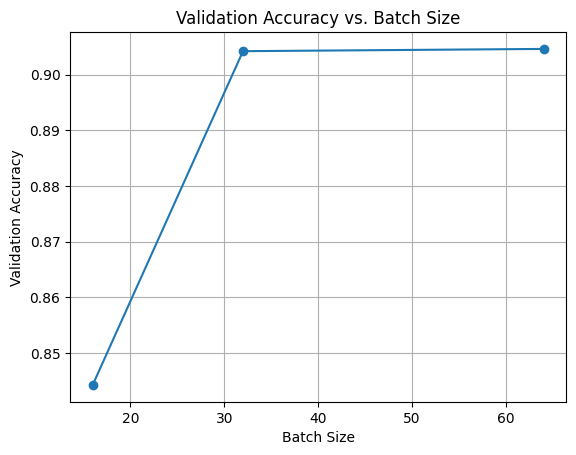


 Best batch_size = 64 with accuracy = 0.9046


In [147]:
# ==== Explore Batch Size ====

batch_sizes = [16, 32, 64]
batch_results = {}

for bs in batch_sizes:
    print(f"\n Training with batch_size = {bs}")

    model = build_cnn_model(
        num_layers=BEST_PARAMS['num_layers'],
        dropout_rate=BEST_PARAMS['dropout_rate'],
        weight_decay=BEST_PARAMS['weight_decay']
    )

    val_acc, _ = train_model_numpy(
        model,
        X_train, y_train,
        X_val, y_val,
        optimizer_name=BEST_PARAMS['optimizer'],
        learning_rate=BEST_PARAMS['learning_rate'],
        batch_size=bs
    )

    batch_results[bs] = val_acc

# Plot
plt.figure()
plt.plot(batch_results.keys(), batch_results.values(), marker='o')
plt.title('Validation Accuracy vs. Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

# Update best batch size
BEST_PARAMS['batch_size'] = max(batch_results, key=batch_results.get)
print(f"\n Best batch_size = {BEST_PARAMS['batch_size']} with accuracy = {batch_results[BEST_PARAMS['batch_size']]:.4f}")



 Training with weight_decay = 0.0
Epoch 1/12
309/309 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.3915 - loss: 2.0482 - val_accuracy: 0.2291 - val_loss: 2.5086 - learning_rate: 0.0010
Epoch 2/12
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6284 - loss: 1.0942 - val_accuracy: 0.6834 - val_loss: 0.9236 - learning_rate: 0.0010
Epoch 3/12
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7126 - loss: 0.8345 - val_accuracy: 0.7373 - val_loss: 0.7988 - learning_rate: 0.0010
Epoch 4/12
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7543 - loss: 0.7108 - val_accuracy: 0.7829 - val_loss: 0.6455 - learning_rate: 0.0010
Epoch 5/12
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7845 - loss: 0.6124 - val_accuracy: 0.8145 - val_loss: 0.5406 - learning_rate: 0.0010
Epoch 6/12
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8138 - loss: 0.5395 - val_accuracy: 0.8007 - val_loss: 0.5910 - learning_rate: 0.0010
Epoch 7/12
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12m

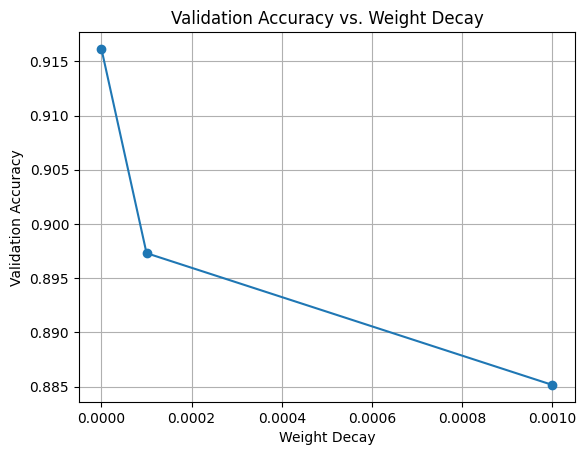


 Best weight_decay = 0.0 with accuracy = 0.9161


In [148]:
# ==== Explore Weight Decay ====

weight_decays = [0.0, 1e-4, 1e-3]
decay_results = {}

for decay in weight_decays:
    print(f"\n Training with weight_decay = {decay}")
    
    model = build_cnn_model(
        num_layers=BEST_PARAMS['num_layers'],
        dropout_rate=BEST_PARAMS['dropout_rate'],
        weight_decay=decay
    )

    val_acc, _ = train_model_numpy(
        model,
        X_train, y_train,
        X_val, y_val,
        optimizer_name=BEST_PARAMS['optimizer'],
        learning_rate=BEST_PARAMS['learning_rate'],
        batch_size=BEST_PARAMS['batch_size']
    )

    decay_results[decay] = val_acc

# Plot
plt.figure()
plt.plot(decay_results.keys(), decay_results.values(), marker='o')
plt.title('Validation Accuracy vs. Weight Decay')
plt.xlabel('Weight Decay')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

# Update
BEST_PARAMS['weight_decay'] = max(decay_results, key=decay_results.get)
print(f"\n Best weight_decay = {BEST_PARAMS['weight_decay']} with accuracy = {decay_results[BEST_PARAMS['weight_decay']]:.4f}")



 Training with optimizer = Adam
Epoch 1/12
309/309 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.3940 - loss: 1.9792 - val_accuracy: 0.2177 - val_loss: 2.2249 - learning_rate: 0.0010
Epoch 2/12
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6351 - loss: 1.0438 - val_accuracy: 0.6231 - val_loss: 1.0998 - learning_rate: 0.0010
Epoch 3/12
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7048 - loss: 0.8455 - val_accuracy: 0.7320 - val_loss: 0.7701 - learning_rate: 0.0010
Epoch 4/12
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7522 - loss: 0.7145 - val_accuracy: 0.7697 - val_loss: 0.6584 - learning_rate: 0.0010
Epoch 5/12
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7890 - loss: 0.6116 - val_accuracy: 0.7942 - val_loss: 0.5887 - learning_rate: 0.0010
Epoch 6/12
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8145 - loss: 0.5424 - val_accuracy: 0.8163 - val_loss: 0.5419 - learning_rate: 0.0010
Epoch 7/12
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/

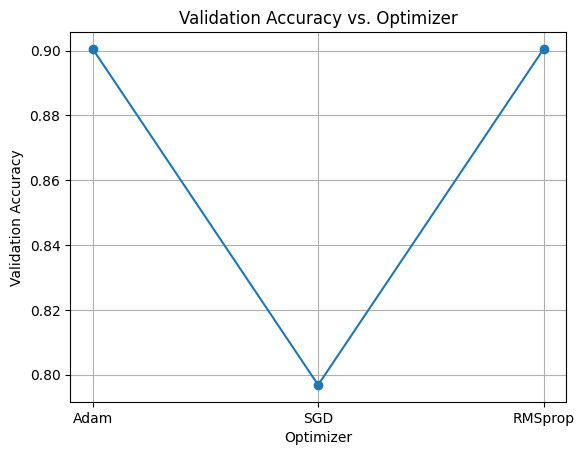


 Best optimizer = Adam with accuracy = 0.9005


In [149]:
# ==== Explore Optimizer ====

optimizers = ['Adam', 'SGD', 'RMSprop']
opt_results = {}

for opt in optimizers:
    print(f"\n Training with optimizer = {opt}")
    
    model = build_cnn_model(
        num_layers=BEST_PARAMS['num_layers'],
        dropout_rate=BEST_PARAMS['dropout_rate'],
        weight_decay=BEST_PARAMS['weight_decay']
    )

    val_acc, _ = train_model_numpy(
        model,
        X_train, y_train,
        X_val, y_val,
        optimizer_name=opt,
        learning_rate=BEST_PARAMS['learning_rate'],
        batch_size=BEST_PARAMS['batch_size']
    )

    opt_results[opt] = val_acc

# Plot
plt.figure()
plt.plot(opt_results.keys(), opt_results.values(), marker='o')
plt.title('Validation Accuracy vs. Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

# Update
BEST_PARAMS['optimizer'] = max(opt_results, key=opt_results.get)
print(f"\n Best optimizer = {BEST_PARAMS['optimizer']} with accuracy = {opt_results[BEST_PARAMS['optimizer']]:.4f}")



 Training with learning_rate = 0.0005
Epoch 1/12
309/309 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.3793 - loss: 2.0442 - val_accuracy: 0.2587 - val_loss: 2.2626 - learning_rate: 5.0000e-04
Epoch 2/12
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6084 - loss: 1.1468 - val_accuracy: 0.6605 - val_loss: 0.9404 - learning_rate: 5.0000e-04
Epoch 3/12
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6821 - loss: 0.9265 - val_accuracy: 0.7264 - val_loss: 0.7928 - learning_rate: 5.0000e-04
Epoch 4/12
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7257 - loss: 0.7860 - val_accuracy: 0.7776 - val_loss: 0.6403 - learning_rate: 5.0000e-04
Epoch 5/12
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7707 - loss: 0.6687 - val_accuracy: 0.8009 - val_loss: 0.5863 - learning_rate: 5.0000e-04
Epoch 6/12
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7970 - loss: 0.5924 - val_accuracy: 0.8055 - val_loss: 0.6044 - learning_rate: 5.0000e-04
Epoch 7/12
309/309

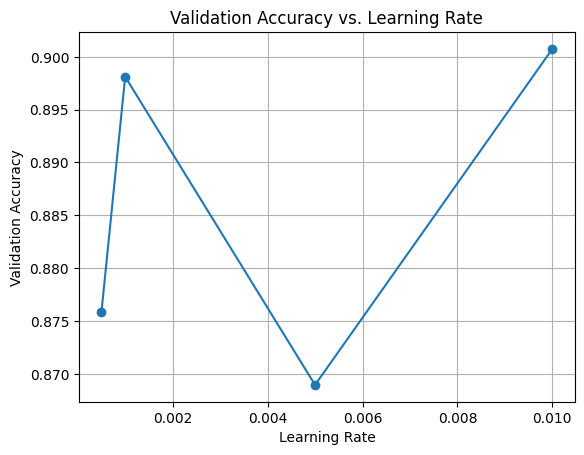


 Best learning_rate = 0.01 with accuracy = 0.9007


In [150]:
# ==== Explore Learning Rate ====

lr_values = [0.0005, 0.001, 0.005, 0.01]
lr_results = {}

for lr in lr_values:
    print(f"\n Training with learning_rate = {lr}")
    
    model = build_cnn_model(
        num_layers=BEST_PARAMS['num_layers'],
        dropout_rate=BEST_PARAMS['dropout_rate'],
        weight_decay=BEST_PARAMS['weight_decay']
    )

    val_acc, _ = train_model_numpy(
        model,
        X_train, y_train,
        X_val, y_val,
        optimizer_name=BEST_PARAMS['optimizer'],
        learning_rate=lr,
        batch_size=BEST_PARAMS['batch_size']
    )

    lr_results[lr] = val_acc

# Plot
plt.figure()
plt.plot(lr_results.keys(), lr_results.values(), marker='o')
plt.title('Validation Accuracy vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

# Update
BEST_PARAMS['learning_rate'] = max(lr_results, key=lr_results.get)
print(f"\n Best learning_rate = {BEST_PARAMS['learning_rate']} with accuracy = {lr_results[BEST_PARAMS['learning_rate']]:.4f}")



 Training with scheduler = none
Epoch 1/12
309/309 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.3774 - loss: 1.9632 - val_accuracy: 0.5268 - val_loss: 1.3385
Epoch 2/12
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5897 - loss: 1.1408 - val_accuracy: 0.4726 - val_loss: 1.6484
Epoch 3/12
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6704 - loss: 0.9221 - val_accuracy: 0.6058 - val_loss: 1.4264
Epoch 4/12
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7205 - loss: 0.8007 - val_accuracy: 0.6611 - val_loss: 1.0876
Epoch 5/12
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7563 - loss: 0.7102 - val_accuracy: 0.5935 - val_loss: 2.3563
Epoch 6/12
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7846 - loss: 0.6361 - val_accuracy: 0.6449 - val_loss: 1.3869
Epoch 7/12
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8033 - loss: 0.5730 - val_accuracy: 0.7515 - val_loss: 0.9147
Epoch 8/12
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy

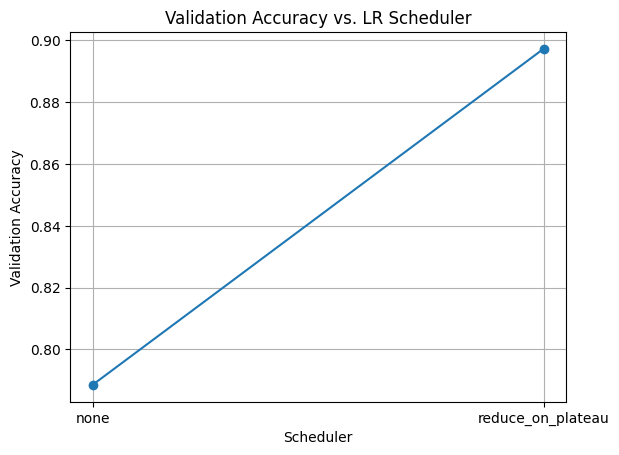


 Best scheduler = reduce_on_plateau with accuracy = 0.8973


In [151]:
# ==== Explore LR Scheduler ====

from tensorflow.keras.callbacks import ReduceLROnPlateau

scheduler_options = {
    'none': None,
    'reduce_on_plateau': ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
}

scheduler_results = {}

for name, sched in scheduler_options.items():
    print(f"\n Training with scheduler = {name}")

    model = build_cnn_model(
        num_layers=BEST_PARAMS['num_layers'],
        dropout_rate=BEST_PARAMS['dropout_rate'],
        weight_decay=BEST_PARAMS['weight_decay']
    )

    val_acc, _ = train_model_numpy(
        model,
        X_train, y_train,
        X_val, y_val,
        optimizer_name=BEST_PARAMS['optimizer'],
        learning_rate=BEST_PARAMS['learning_rate'],
        batch_size=BEST_PARAMS['batch_size'],
        use_scheduler=(sched is not None)
    )

    scheduler_results[name] = val_acc

# Plot
plt.figure()
plt.plot(scheduler_results.keys(), scheduler_results.values(), marker='o')
plt.title('Validation Accuracy vs. LR Scheduler')
plt.xlabel('Scheduler')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

# Update best scheduler
BEST_PARAMS['scheduler'] = max(scheduler_results, key=scheduler_results.get)
print(f"\n Best scheduler = {BEST_PARAMS['scheduler']} with accuracy = {scheduler_results[BEST_PARAMS['scheduler']]:.4f}")


In [152]:
# ==== Final Training 1====
# Rebuild model with best hyperparameters
final_model = build_cnn_model(
    num_layers=BEST_PARAMS['num_layers'],
    dropout_rate=BEST_PARAMS['dropout_rate'],
    weight_decay=BEST_PARAMS['weight_decay']
)

# Choose optimizer
opt_cls = {'Adam': Adam, 'SGD': SGD, 'RMSprop': RMSprop}[BEST_PARAMS['optimizer']]
opt_kwargs = {'learning_rate': BEST_PARAMS['learning_rate']}
if BEST_PARAMS['optimizer'] == 'SGD':
    opt_kwargs['momentum'] = 0.9
optimizer = opt_cls(**opt_kwargs)

# Label smoothing loss
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

# Compile model
final_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=10, monitor='val_accuracy', restore_best_weights=True),
    ModelCheckpoint('final_model_6_5.keras', monitor='val_accuracy', save_best_only=True)
]
if BEST_PARAMS.get('use_scheduler', True):
    callbacks.insert(1, ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3))

# Train
history = final_model.fit(
    X_train/255.0, tf.keras.utils.to_categorical(y_train, NUM_CLASSES),
    validation_data=(X_val/255.0, tf.keras.utils.to_categorical(y_val, NUM_CLASSES)),
    batch_size=BEST_PARAMS['batch_size'],
    epochs=50,
    callbacks=callbacks,
    verbose=1
)



Epoch 1/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.3511 - loss: 2.1317 - val_accuracy: 0.4410 - val_loss: 1.6953 - learning_rate: 0.0100
Epoch 2/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5464 - loss: 1.3980 - val_accuracy: 0.5724 - val_loss: 1.4501 - learning_rate: 0.0100
Epoch 3/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6467 - loss: 1.2097 - val_accuracy: 0.6265 - val_loss: 1.2586 - learning_rate: 0.0100
Epoch 4/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7051 - loss: 1.0866 - val_accuracy: 0.7118 - val_loss: 1.1188 - learning_rate: 0.0100
Epoch 5/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7453 - loss: 1.0257 - val_accuracy: 0.7268 - val_loss: 1.0670 - learning_rate: 0.0100
Epoch 6/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7737 - loss: 0.9632 - val_accuracy: 0.7782 - val_loss: 0.9799 - learning_rate: 0.0100
Epoch 7/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8008 - loss: 0

In [198]:
# === FINAL TRAINING 2 with FUNCTION  ===this is what we will test 
def final_train_modell(X_train, y_train, X_val, y_val, num_classes, best_params, model_name='final_model.keras'):
    import gc
    tf.keras.backend.clear_session()
    gc.collect()

    # Label smoothing loss
    loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

    # Build model
    model = build_cnn_model(
        num_layers=best_params['num_layers'],
        dropout_rate=best_params['dropout_rate'],
        weight_decay=best_params['weight_decay']
    )

    # Optimizer
    opt_cls = {'Adam': Adam, 'SGD': SGD, 'RMSprop': RMSprop}[best_params['optimizer']]
    opt_kwargs = {'learning_rate': best_params['learning_rate']}
    if best_params['optimizer'] == 'SGD':
        opt_kwargs['momentum'] = 0.9
    optimizer = opt_cls(**opt_kwargs)

    # Compile model
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
    # Callbacks
    callbacks = [
        EarlyStopping(patience=10, monitor='val_accuracy', restore_best_weights=True),
        ModelCheckpoint(model_name, monitor='val_accuracy', save_best_only=True)
    ]
    if best_params.get('use_scheduler', True):
        callbacks.insert(1, ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3))

    # Convert labels to one-hot
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

    # Train
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        batch_size=best_params['batch_size'],
        epochs=50,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

In [199]:
# Final model training
final_modell, history = final_train_model(
    X_train_standardized, y_train,
    X_val_standardized, y_val,
    num_classes=NUM_CLASSES,
    best_params=BEST_PARAMS,
    model_name='final_model.keras'
)


Epoch 1/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 27s 50ms/step - accuracy: 0.3917 - loss: 1.9468 - val_accuracy: 0.5821 - val_loss: 1.3391 - learning_rate: 0.0100
Epoch 2/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6074 - loss: 1.2942 - val_accuracy: 0.6139 - val_loss: 1.3321 - learning_rate: 0.0100
Epoch 3/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.6799 - loss: 1.1506 - val_accuracy: 0.6257 - val_loss: 1.4888 - learning_rate: 0.0100
Epoch 4/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7234 - loss: 1.0605 - val_accuracy: 0.7073 - val_loss: 1.2085 - learning_rate: 0.0100
Epoch 5/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7628 - loss: 0.9820 - val_accuracy: 0.7343 - val_loss: 1.1184 - learning_rate: 0.0100
Epoch 6/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7878 - loss: 0.9354 - val_accuracy: 0.7719 - val_loss: 1.0057 - learning_rate: 0.0100
Epoch 7/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8143 - loss: 0

In [200]:
# === EVALUATION FUNCTION ===
def evaluate_model(model, X_val, y_val, class_names):
    print("\n=== Model Evaluation ===")

    y_val_cat = tf.keras.utils.to_categorical(y_val, len(class_names))
    val_loss, val_acc = model.evaluate(X_val, y_val_cat, verbose=1)
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")

    y_pred_probs = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred_classes)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return val_acc


=== Model Evaluation ===
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9906 - loss: 0.4937
Validation Accuracy: 0.9889
Validation Loss: 0.4981
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

Classification Report:
              precision    recall  f1-score   support

   Badminton       1.00      0.99      0.99       836
     Cricket       0.99      1.00      0.99       934
      Karate       0.97      0.98      0.98       347
      Soccer       0.99      0.98      0.99       713
    Swimming       0.99      0.99      0.99       357
      Tennis       0.99      0.98      0.98       867
   Wrestling       0.98      1.00      0.99       883

    accuracy                           0.99      4937
   macro avg       0.99      0.99      0.99      4937
weighted avg       0.99      0.99      0.99      4937



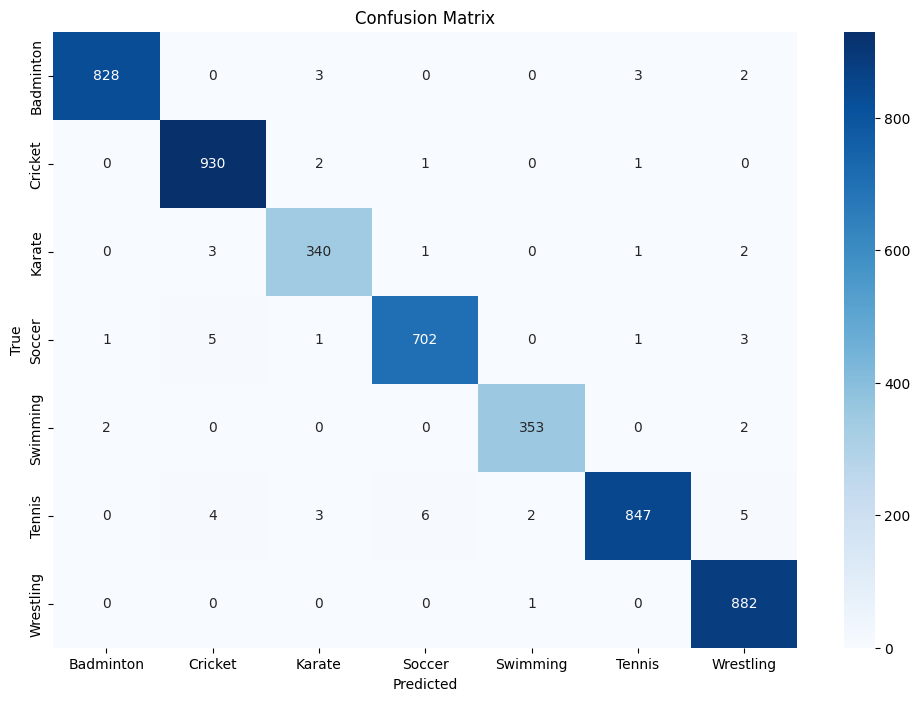

 Final Evaluation Accuracy: 0.9889


In [201]:
# Evaluate the final model
val_accuracy = evaluate_model(
    final_modell,
    X_val_standardized,
    y_val,
    class_names=le.classes_
)

print(f" Final Evaluation Accuracy: {val_accuracy:.4f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


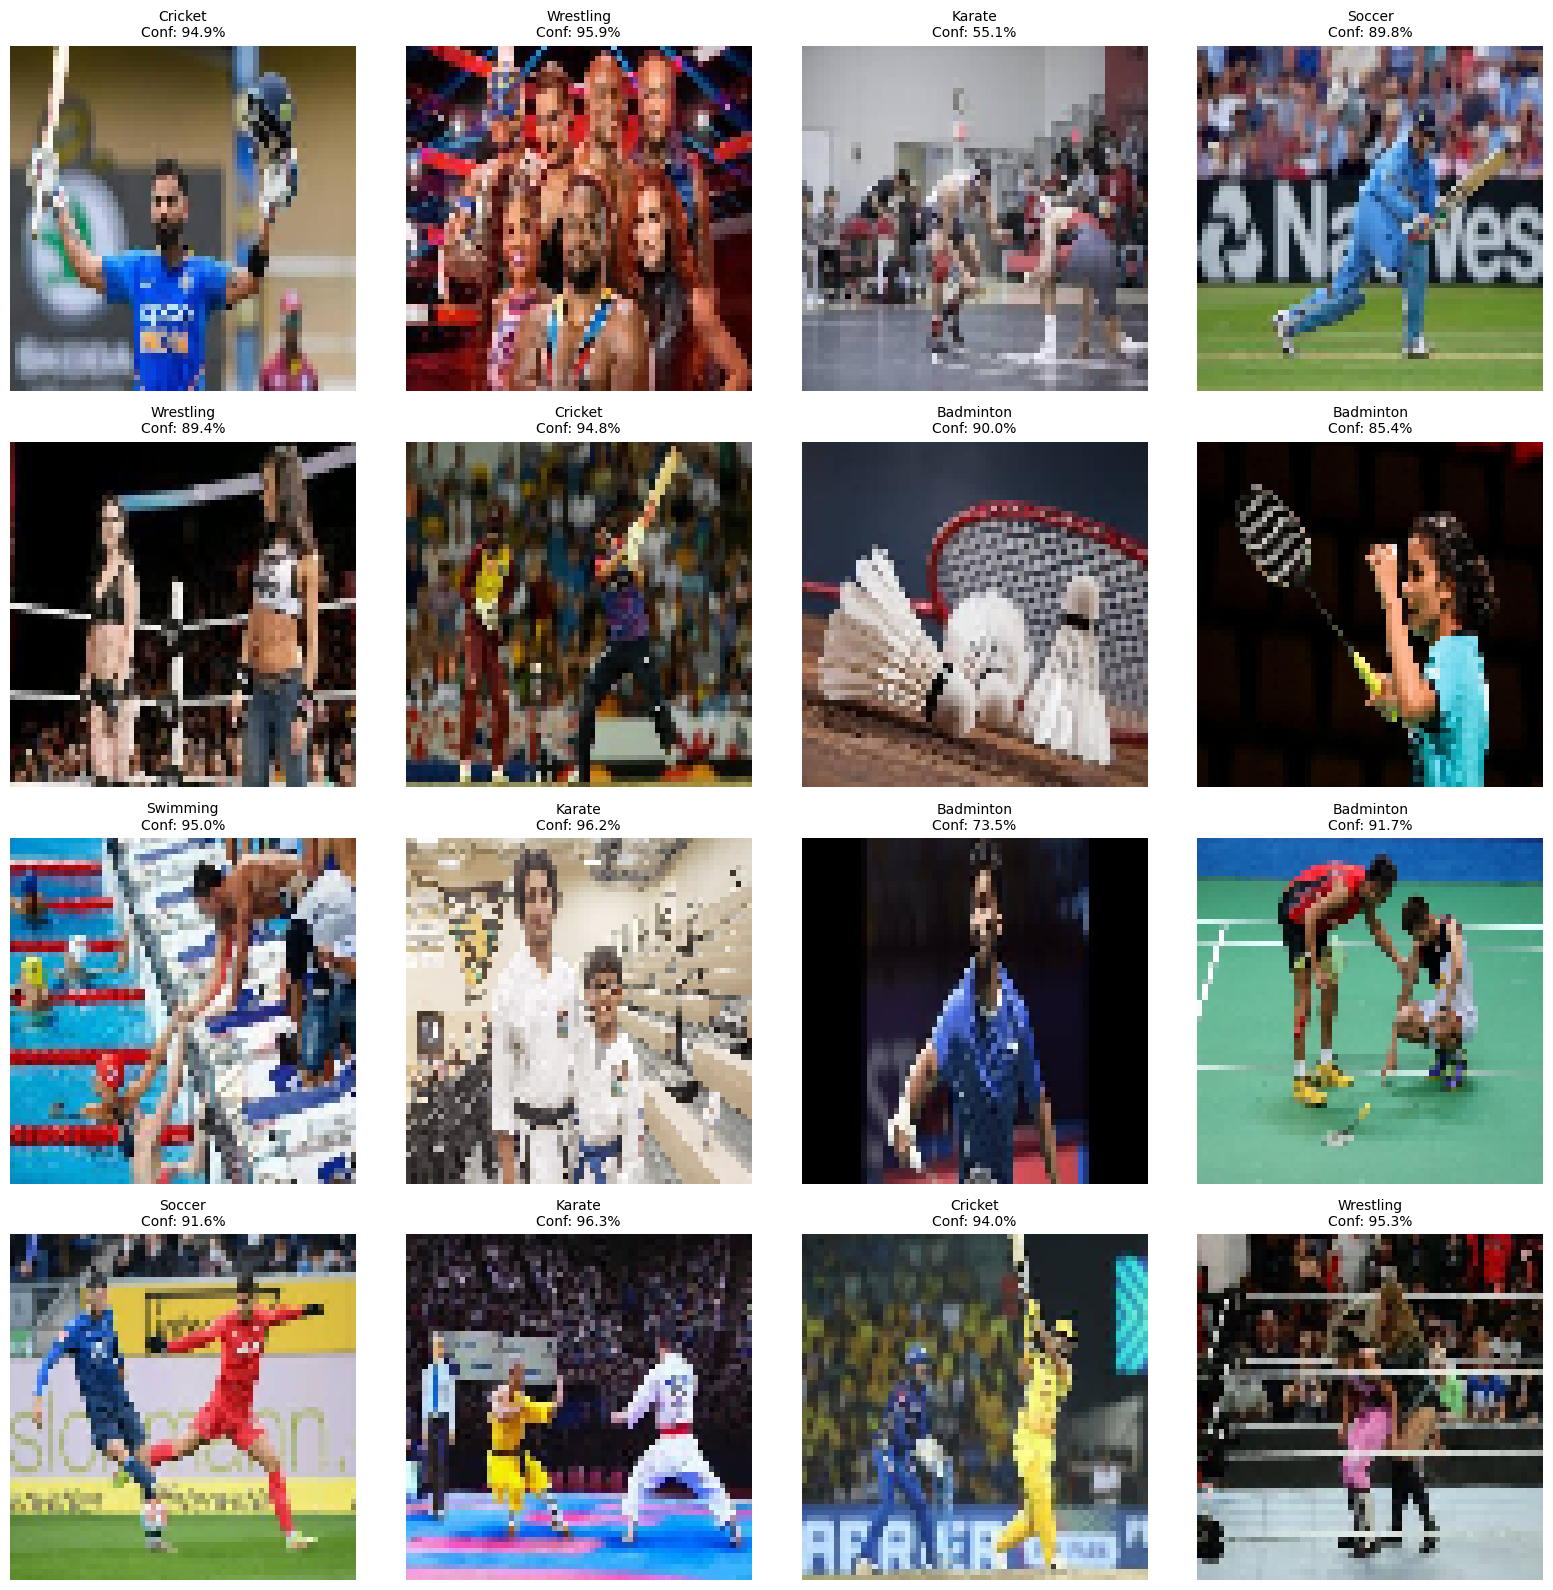

In [207]:
# === LOAD & PREVIEW TEST IMAGES ===

test_samples = test_df.sample(16, random_state=42)
X_test_preview = load_test_images(test_samples, TEST_IMG_DIR, img_size=IMG_SIZE)
X_test_preview_std = (X_test_preview - train_mean) / train_std

# Predict
pred_probs = final_modell.predict(X_test_preview_std)
pred_classes = np.argmax(pred_probs, axis=1)
pred_labels = label_encoder.inverse_transform(pred_classes)

# Display
plt.figure(figsize=(16, 16))
for i in range(len(test_samples)):
    img = X_test_preview[i]
    label = pred_labels[i]
    confidence = pred_probs[i][pred_classes[i]] * 100
    
    plt.subplot(4, 4, i + 1)
    plt.imshow(img.astype(np.uint8))
    plt.title(f"{label}\nConf: {confidence:.1f}%", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


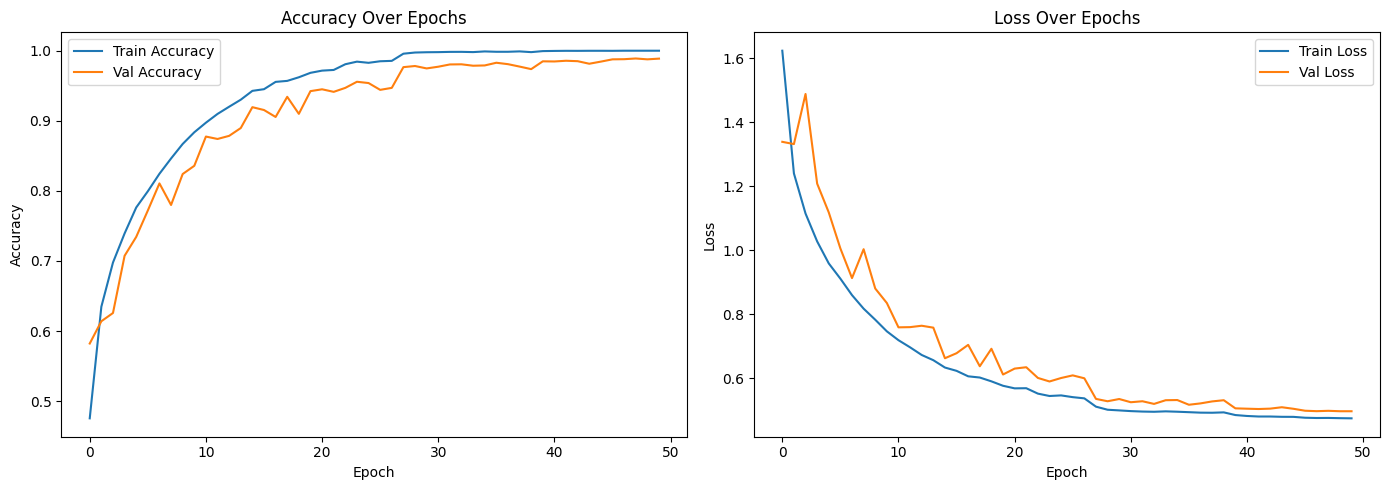

155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


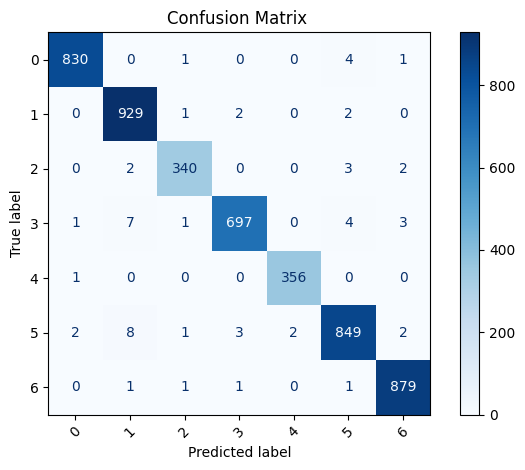

In [204]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# ===== TRAINING HISTORY + CONFUSION MATRIX =====

def plot_history_and_confusion(history, model, X_val, y_val, title=""):
    # Plot history
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Confusion Matrix
    y_true = y_val
    y_pred = np.argmax(model.predict(X_val / 255.0), axis=1)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f'Confusion Matrix {title}')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Call the function
plot_history_and_confusion(history, final_model, X_val, y_val)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


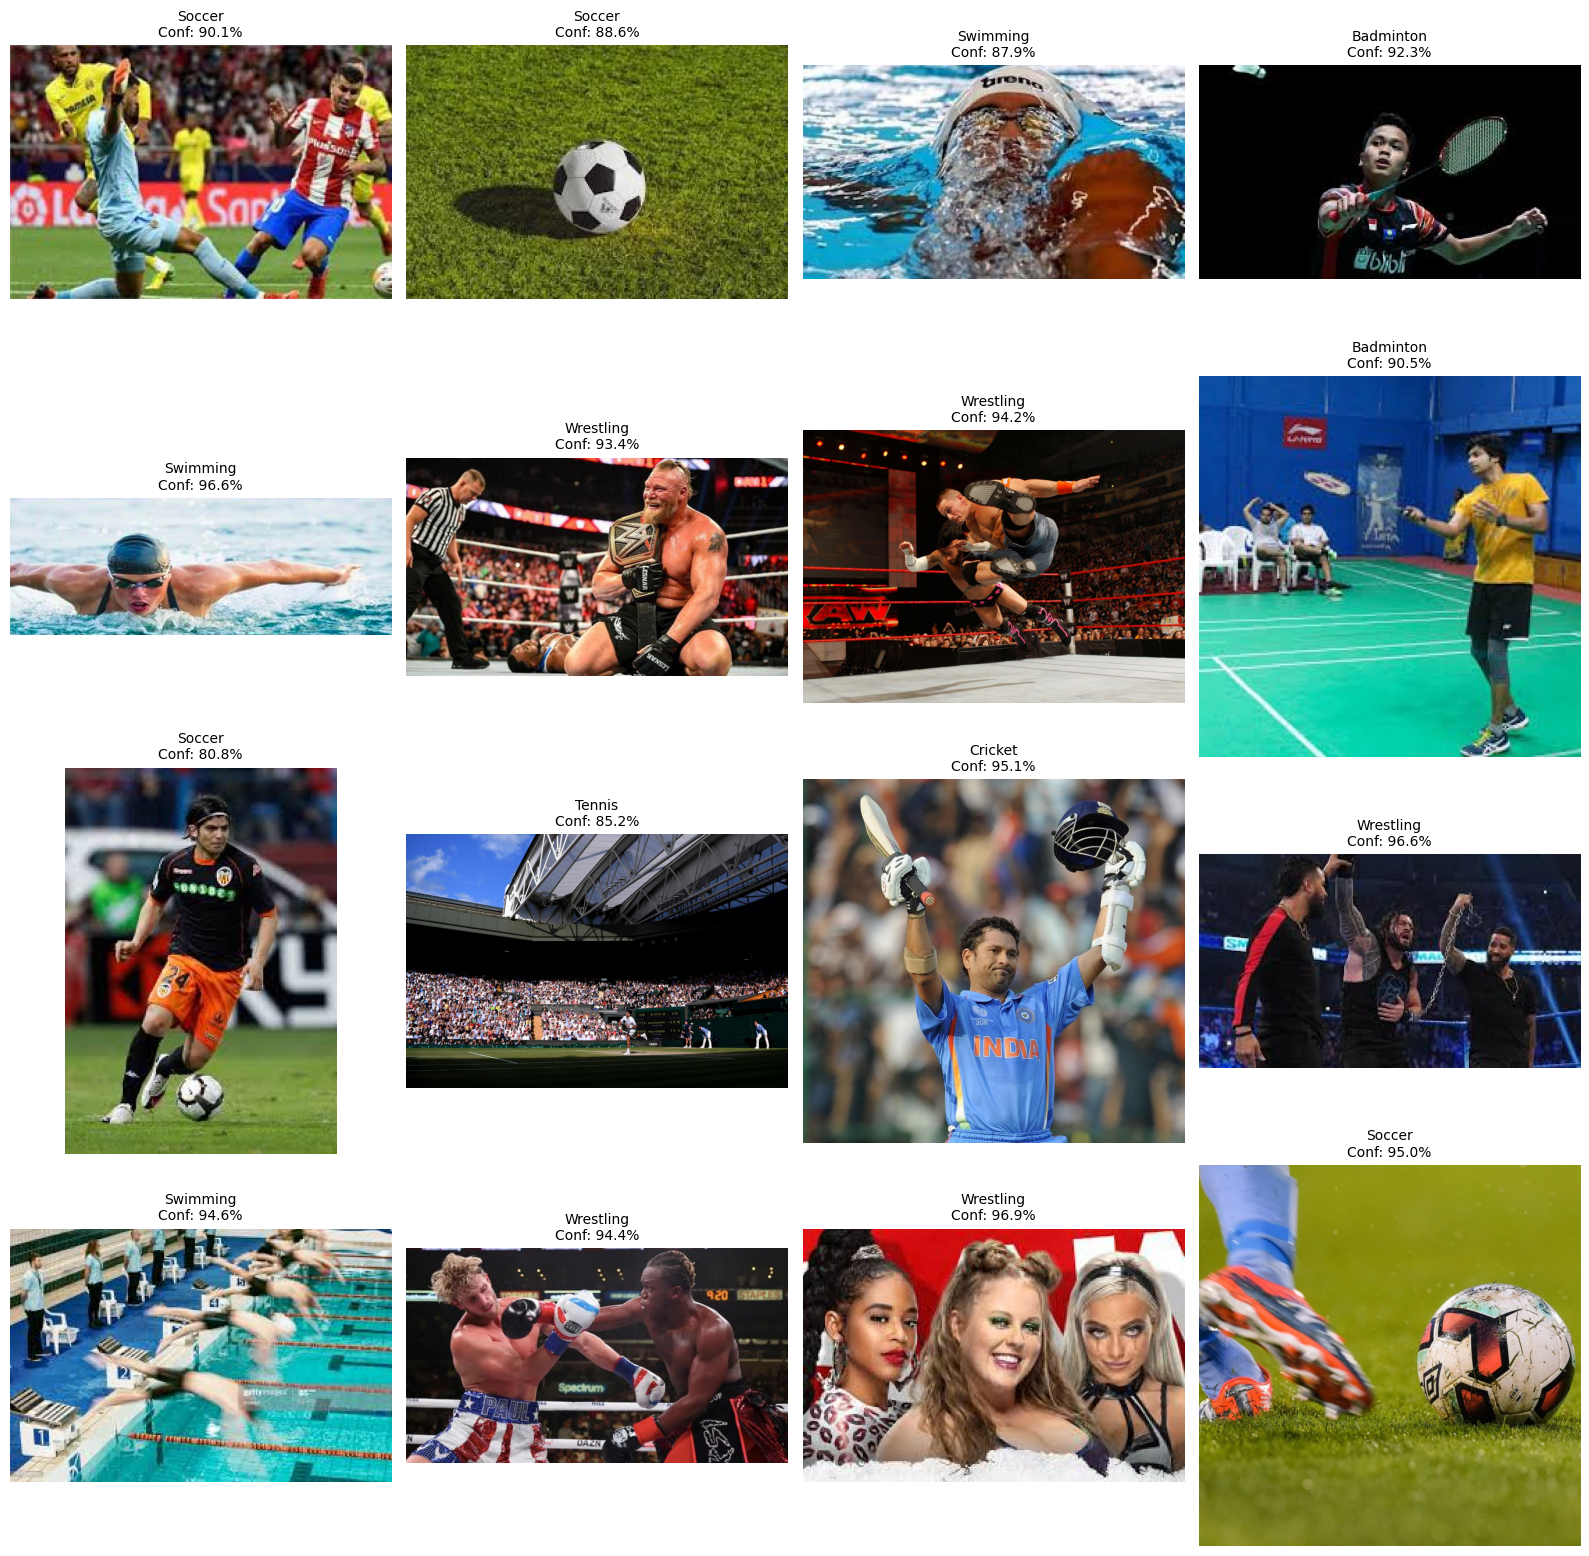

In [205]:
# ===== PREDICT & DISPLAY SAMPLE TEST IMAGES =====
test_samples = test_df.sample(16)

plt.figure(figsize=(16, 16))
rows, cols = 4, 4

for i, (_, row) in enumerate(test_samples.iterrows()):
    img_path = os.path.join(TEST_IMG_DIR, row['image_ID'])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Preprocess (standardize using train mean/std)
    img_processed = (img_resized - train_mean) / train_std
    img_processed = np.expand_dims(img_processed, axis=0)

    pred = final_modell.predict(img_processed)[0]
    pred_class = np.argmax(pred)
    pred_label = label_encoder.classes_[pred_class]
    confidence = pred[pred_class] * 100

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"{pred_label}\nConf: {confidence:.1f}%", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [206]:
print("\n Final CNN Architecture:")
final_modell.summary()
final_modell.save('final_model_acc_66-55.keras')
print(" Final model saved.")



 Final CNN Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 971,127 (3.70 MB)

 Trainable params: 323,239 (1.23 MB)

 Non-trainable params: 1,408 (5.50 KB)

 Optimizer params: 646,480 (2.47 MB)

 Final model saved.


In [ ]:
import random
from tensorflow.keras.preprocessing.image import load_img
sample_indices = random.sample(range(len(test_gen.filenames)), 8)

plt.figure(figsize=(16, 8))
for i, idx in enumerate(sample_indices):
    image_path = os.path.join(TEST_IMG_DIR, test_gen.filenames[idx])
    image = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))

    plt.subplot(2, 4, i+1)
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_labels[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [33]:
print(BEST_PARAMS)

{'batch_size': 32, 'num_layers': 4, 'dropout_rate': 0.3, 'weight_decay': 0.0, 'optimizer': 'Adam', 'learning_rate': 0.001, 'scheduler': 'reduce_on_plateau'}


In [ ]:
print("all cells successfully trained ")

In [208]:
# import os
# from IPython.display import FileLink, display

# # Paths (assumed already in /kaggle/working)
# model_path = 'best_sports_classifier.keras'
# sub_path   = 'submission.csv'
# zip_path   = 'output.zip'

# # 1) Zip them (if you want one download)
# #    - the `-j` flag puts them in the root of the zip without folders
# !zip -j {zip_path} {model_path} {sub_path}

# # 2) Display download links
# display(FileLink(model_path, result_html_prefix=" Download model: "))
# display(FileLink(sub_path,   result_html_prefix=" Download submission: "))
# display(FileLink(zip_path,   result_html_prefix=" Download both as ZIP: "))
